In [1]:
import netCDF4 as nc 
# miscellaneous operating system interfaces
import os

# visualizes the data
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

#processes the data
import numpy as np 
import pandas as pd

# helps visualize the data
import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes

In [2]:
# LOAD DATA
file_path = '../homework1/data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc'

# Check if the file exists
if os.path.exists(file_path):
    mascons = nc.Dataset(file_path)
else:
    raise FileNotFoundError(f"File not found: {file_path}")

In [4]:
# try to reformat time into months
from datetime import datetime, timedelta

# Extract necessary variables
time_data = mascons.variables['time'][:]  # Time in days since 2002-01-01T00:00:00Z
lwe_thickness = mascons.variables['lwe_thickness'][:]  # Shape (239, 360, 720)

# Step 1: Convert time to datetime
start_date = datetime(2002, 1, 1)
time_dates = np.array([start_date + timedelta(days=int(t)) for t in time_data])

# Step 2: Create a pandas DataFrame for grouping
time_df = pd.DataFrame({'time': time_dates})
time_df['year_month'] = time_df['time'].dt.to_period('M')  # Convert to 'YYYY-MM' format for grouping

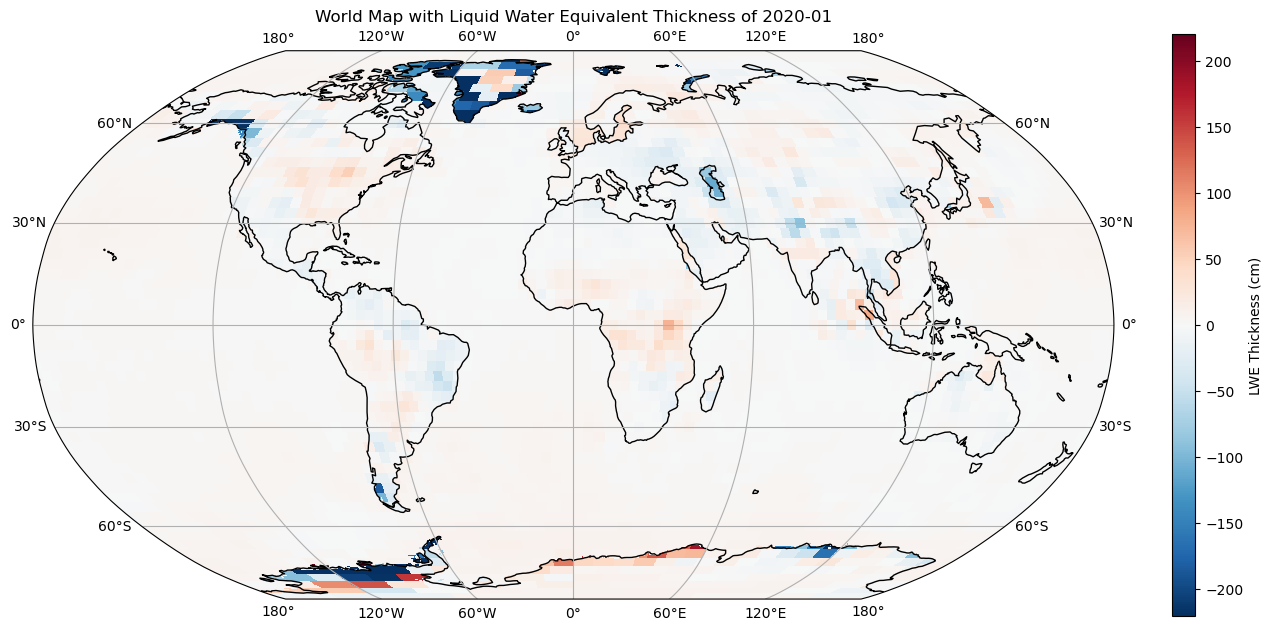

In [6]:
# Create a figure and an axis with a size and specific projection
fig, ax = plt.subplots(figsize=(15, 10), 
                       subplot_kw={'projection': ccrs.Robinson()}) # eg robinson, mercator, PlateCarree
# set global information
ax.set_global() # Set the extent to show the whole world
ax.coastlines() # Add coastlines
ax.gridlines(draw_labels=True) # Add gridlines

# set names for data
lon = mascons.variables['lon'][:]
lat = mascons.variables['lat'][:]
lwe_thickness = mascons.variables['lwe_thickness'][:]

# Select a month for plotting
timestep = 180
lwe_thickness_single = lwe_thickness[timestep, :, :]  # Adjust the index as needed
month = time_df['year_month'][timestep] ##??

# Plot the lwe_thickness data
lon_grid, lat_grid = np.meshgrid(lon, lat)  # Create a 2D grid of lon and lat
lwe_min, lwe_max = -220, 220 # why is it set to this? why -220 and 220?
plot = ax.pcolormesh(lon_grid, lat_grid, lwe_thickness_single, 
                     transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=lwe_min, vmax=lwe_max)

# Add a colorbar for the lwe_thickness
cbar = plt.colorbar(plot, orientation='vertical', pad=0.05, aspect=25, fraction=0.02) # pad = distance to plot, aspect = thickness of bar, fraction = height
cbar.set_label('LWE Thickness (cm)')

# set title and axes
plt.title(f'World Map with Liquid Water Equivalent Thickness of {month}')

# Display the map
plt.show()

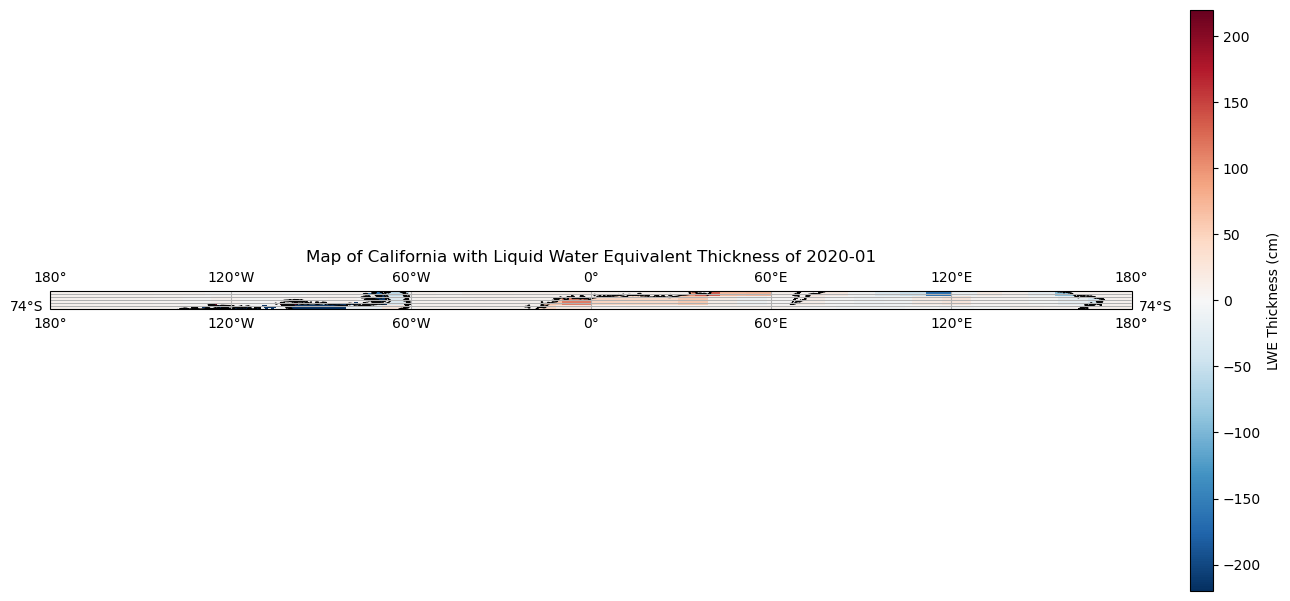

In [20]:
# area: California, USA
# Create a figure and an axis with a size and specific projection
fig, ax = plt.subplots(figsize=(15, 10), 
                       subplot_kw={'projection': ccrs.PlateCarree()}) # eg robinson, mercator, PlateCarree
# set global information
# ax.set_global() # Set the extent to show the whole world
ax.coastlines() # Add coastlines
ax.gridlines(draw_labels=True) # Add gridlines

# set names for data
min_lon, max_lon = 230, 250 # California, USA
min_lat, max_lat = 30, 42 # California, USA
lon_area = np.concatenate((lon[min_lon:], lon[:max_lon]))
lat_area = lat[min_lat:max_lat]
lwe_thickness_area = np.concatenate([lwe_thickness_single[min_lat:max_lat,min_lon:], lwe_thickness_single[min_lat:max_lat,:max_lon]], axis=1)

# Plot the lwe_thickness data
lon_grid, lat_grid = np.meshgrid(lon_area, lat_area)  # Create a 2D grid of lon and lat
lwe_min, lwe_max = -220, 220
plot = ax.pcolormesh(lon_grid, lat_grid, lwe_thickness_area, 
                     transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=lwe_min, vmax=lwe_max)

# Add a colorbar for the lwe_thickness
cbar = plt.colorbar(plot, orientation='vertical', pad=0.05, aspect=25, fraction=0.02) # pad = distance to plot, aspect = thickness of bar, fraction = height
cbar.set_label('LWE Thickness (cm)')

# set title and axes
plt.title(f'Map of California with Liquid Water Equivalent Thickness of {month}')

# Display the map
plt.show()